In [1]:
# data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html
from pyntcloud import PyntCloud
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
if sys.platform == 'darwin':
    data_path = os.getcwd() + "/PartAnnotation"
else:
    data_path = os.getcwd() + "\\PartAnnotation"

# Data explorer

Data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html

Rename the folder into proper class names if you want to see the results properly. It won't affect the results but it is better to see a proper label rather than random numbers.

In [2]:
def count_data(data_path):
    """
    Will read all the data under specific data path
    
    Return:
        cate: a dict which all the names encoded by numbers
        label: a dict contains all the number & name mappings.
    """
    cate = {}
    label = {}
    count = 0
    for entry in os.scandir(data_path):
        if entry.is_dir():
            for pts_data in os.scandir(os.path.join(data_path, entry.name, 'points')):
                if count in cate:
                    cate.update({count: cate.get(count) + 1})
                else:
                    cate.update({count: 1})
                    label.update({count: entry.name})
            count += 1
    return cate, label

In [3]:
cate, label = count_data(data_path)

In [4]:
print(cate)
print(label)

{0: 73, 1: 2318, 2: 7497, 3: 307, 4: 797, 5: 6778, 6: 337, 7: 56, 8: 8509, 9: 4045, 10: 152, 11: 214, 12: 85, 13: 460, 14: 83, 15: 424}
{0: 'earphone', 1: 'lamp', 2: 'car', 3: 'pistol', 4: 'guitar', 5: 'chair', 6: 'motorbike', 7: 'cap', 8: 'table', 9: 'airplane', 10: 'skateboard', 11: 'mug', 12: 'rocket', 13: 'laptop', 14: 'bag', 15: 'knife'}


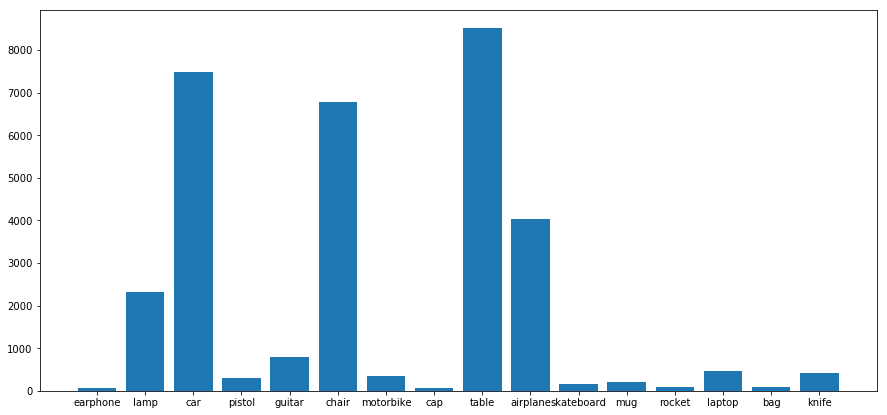

In [5]:
fig = plt.figure(figsize=(15,7))

plt.bar(left=list(cate), height=cate.values())
plt.xticks(list(cate), list(label.values()))
plt.show()

In [70]:
def find_data(data_path, max_file_num=None, min_file_num=None):
    """
    Find file in each folder according to the 'data_path'.
    
    Giving the max and min number of files via `max_file_num`, `min_file_num`.
    
    `min_file_num` will skip the folders which doesn't meet the `min_file_num` threshold.
    """
    if max_file_num is not None and min_file_num is not None:
        assert(max_file_num > min_file_num), "`max_file_num` should be greater than `min_file_num`"
        
    data = []
    label = []
    for entry in os.scandir(data_path):
        if entry.is_dir():
            target_dir_path = os.path.join(data_path, entry.name, 'points')
            path, dirs, files = os.walk(target_dir_path).__next__()
            file_count = len(files)
            if (min_file_num is None) or (file_count > min_file_num):
                count = 0
                for pts_data in os.scandir(target_dir_path):
                    if (max_file_num is None) or (count < max_file_num):
                        data.append(os.path.join(data_path, entry.name, 'points', pts_data.name))
                        label.append(entry.name)
                        count += 1
                    else:
                        break
    return data, label

In [71]:
data, label = find_data(data_path, 10)

# Plot

In [72]:
my_point_cloud = PyntCloud.from_file(data[30], sep=" ", header=0, names=["x","y","z"])

In [73]:
label[30]

'pistol'

In [74]:
my_point_cloud.add_structure("voxelgrid", x_y_z=[32, 32, 32])

my_point_cloud.plot(point_size=0.005)

In [76]:
import math
import numpy as np

def voxelize3D(pts, dim=[1,1,1]):
    """
    pts: receives .pts cloud point data. 2D array, arbitary sized X,Y,Z pairs.
    dim: dimensioin of output voxelized data
    
    .pts data X, Y, Z ranged from -0.5~0.5.
    This function will locate the grid cube and calculate the density of each cube.
    """
    assert(pts.shape[1]==3)
    assert(len(dim)==3)
    
    x_grid_length = 1/dim[0]
    y_grid_length = 1/dim[1]
    z_grid_length = 1/dim[2]
    
    output = np.zeros((dim[0],dim[1],dim[2])) # Make a 10 by 20 by 30 array
    
    for pair in pts:
        x_loc = int(pair[0]/x_grid_length) + int(dim[0]/2)
        y_loc = int(pair[1]/y_grid_length) + int(dim[1]/2)
        z_loc = int(pair[2]/z_grid_length) + int(dim[2]/2)
        if output[x_loc, y_loc, z_loc] is None:
            output[x_loc, y_loc, z_loc] = 1
        else:
            output[x_loc, y_loc, z_loc] += 1
            
    return output

In [77]:
# %load ./voxel_grid_plot.py
import os
import shutil

import numpy as np

from IPython.display import IFrame
from matplotlib import pyplot as plt


def plot_voxelgrid(voxelgrid,
                   output_name=None,
                   cmap="Oranges",
                   axis=True,
                   width=800,
                   height=600):

    scaled_shape = voxelgrid.shape

    vector = voxelgrid
    points = np.argwhere(vector) * scaled_shape

    s_m = plt.cm.ScalarMappable(cmap=cmap)
    rgb = s_m.to_rgba(vector.reshape(-1)[vector.reshape(-1) > 0])

    camera_position = points.max(0) + abs(points.max(0))

    look = points.mean(0)

    if axis:
        axis_size = points.ptp() * 1.5
    else:
        axis_size = 0

    placeholders = {}

    placeholders["POINTS_X_PLACEHOLDER"] = points[:, 0].tolist()
    placeholders["POINTS_Y_PLACEHOLDER"] = points[:, 1].tolist()
    placeholders["POINTS_Z_PLACEHOLDER"] = points[:, 2].tolist()

    placeholders["R_PLACEHOLDER"] = rgb[:, 0].tolist()
    placeholders["G_PLACEHOLDER"] = rgb[:, 1].tolist()
    placeholders["B_PLACEHOLDER"] = rgb[:, 2].tolist()

    placeholders["S_x_PLACEHOLDER"] = scaled_shape[0]
    placeholders["S_y_PLACEHOLDER"] = scaled_shape[1]
    placeholders["S_z_PLACEHOLDER"] = scaled_shape[2]

    placeholders["CAMERA_X_PLACEHOLDER"] = camera_position[0]
    placeholders["CAMERA_Y_PLACEHOLDER"] = camera_position[1]
    placeholders["CAMERA_Z_PLACEHOLDER"] = camera_position[2]

    placeholders["LOOK_X_PLACEHOLDER"] = look[0]
    placeholders["LOOK_Y_PLACEHOLDER"] = look[1]
    placeholders["LOOK_Z_PLACEHOLDER"] = look[2]

    placeholders["AXIS_SIZE_PLACEHOLDER"] = axis_size

    placeholders["N_VOXELS_PLACEHOLDER"] = sum(vector.reshape(-1) > 0)

    if output_name is None:
        output_name = "plotVG.html"

    BASE_PATH = os.getcwd()
    src = "{}/{}".format(BASE_PATH, "voxelgrid.html")
    dst = "{}/{}".format(os.getcwd(), output_name)

    with open(src, "r") as inp, open(dst, "w") as out:
        for line in inp:
            for key, val in placeholders.items():
                if key in line:
                    line = line.replace(key, str(val))
            out.write(line)

    return IFrame(output_name, width=width, height=height)

In [78]:
print("Zoom in a little bit, seems like some visual bugs inside the code if you have a large set of points")
vox = voxelize3D(my_point_cloud.xyz, dim=[32,32,32])
plot_voxelgrid(vox)

Zoom in a little bit, seems like some visual bugs inside the code if you have a large set of points


# Data Reading & preprocessing

In [14]:
def label_cates(labels):
    cates = []
    for l in labels:
        if l not in cates:
            cates.append(l)
    return cates

def data_onehot_encode(labels):
    """
    Recieves an array of labels.
    """
    cates = label_cates(labels)
    # one-hot
    onehot = []
    for l in labels:
        x = np.zeros(len(cates))
        x[cates.index(l)] = 1.0
        onehot.append(x)
    return onehot

In [15]:
def data_reshape(data):
    """
    Will read and voxelize the data
    """
    x_reshaped = []
    
    for i in range(len(data)):
        if i % 20 == 0:
            print("Process: ", str('{0:.2f}'.format(i/len(data))) + "%", end='\r')
        my_point_cloud = PyntCloud.from_file(data[i], sep=" ", header=0, names=["x","y","z"])
        vox = voxelize3D(my_point_cloud.xyz, [32,32,32])
        vox_chan = np.array(vox).reshape(vox.shape + (1,))
        x_reshaped.append(vox_chan)
        
    print("Process: ", " 100% ")        
    return x_reshaped

# Data Shuffling

In [16]:
def data_swap(data, index_a, index_b):
    temp = data[index_a]
    data[index_a] = data[index_b]
    data[index_b] = temp
    return data

def data_random_position(data):
    import random
    return random.randint(0,len(data)-1)

def data_shuffling(data, label):
    for i in range(len(data)):
        target = data_random_position(data)
        data = data_swap(data, i, target)
        label = data_swap(label, i, target)
    return data, label

In [17]:
shuffled_data_raw, shuffled_label_raw = data_shuffling(data, label)

In [18]:
shuffled_data = data_reshape(shuffled_data_raw)
shuffled_label = data_onehot_encode(shuffled_label_raw)

Process:   100% 


In [19]:
label_classes = label_cates(label)

In [20]:
print(shuffled_data[100].shape)
print(shuffled_label[100])
print(label_classes)

(32, 32, 32, 1)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
['table', 'chair', 'lamp', 'knife', 'car', 'skateboard', 'rocket', 'guitar', 'airplane', 'bag', 'pistol', 'laptop', 'motorbike', 'cap', 'earphone', 'mug']


# TODO:
Data normalization for different size of pics.

It does not matter for this dataset since we got similar size of pics. But if we have a pic with 10MB, the density of the pic would be larger than what we have now.

The point is to normalize all the data to standard level.

In [21]:
import tensorflow as tf

with tf.name_scope('inputs'):
    x_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 32, 1])
    y_input = tf.placeholder(tf.float32, shape=[None, len(label_classes)]) 

In [22]:
def cnn_model(x_train_data, label_size, keep_rate=0.7, seed=None):
    
    with tf.name_scope("layer_a"):
        # conv => 32*32*32
        conv1 = tf.layers.conv3d(inputs=x_train_data, filters=16, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 32*32*32
        conv2 = tf.layers.conv3d(inputs=conv1, filters=32, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 16*16*16
        pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("layer_b"):
        # conv => 16*16*16
        conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 16*16*16
        conv5 = tf.layers.conv3d(inputs=conv4, filters=128, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 8*8*8
        pool6 = tf.layers.max_pooling3d(inputs=conv5, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("layer_c"):
        # conv => 8*8*8
        conv7 = tf.layers.conv3d(inputs=pool6, filters=256, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # conv => 8*8*8
        conv8 = tf.layers.conv3d(inputs=conv7, filters=512, kernel_size=[3,3,3], padding='same', activation=tf.nn.relu)
        # pool => 4*4*4
        pool9 = tf.layers.max_pooling3d(inputs=conv8, pool_size=[2, 2, 2], strides=2)
        
    with tf.name_scope("batch_norm"):
        cnn3d_bn = tf.layers.batch_normalization(inputs=pool9, training=True)
        
    with tf.name_scope("fully_con"):
        flattening = tf.reshape(cnn3d_bn, [-1, 4*4*4*512])
        dense = tf.layers.dense(inputs=flattening, units=1024, activation=tf.nn.relu)
        # (1-keep_rate) is the probability that the node will be kept
        dropout = tf.layers.dropout(inputs=dense, rate=keep_rate, training=True)
        
    with tf.name_scope("y_conv"):
        y_conv = tf.layers.dense(inputs=dropout, units=label_size)
    
    return y_conv

In [28]:
def train_neural_network(x_train_data, y_train_data, x_test_data, y_test_data, learning_rate=0.1, keep_rate=0.7, epochs=10, batch_size=128, using_gpu=False):

    if using_gpu:
        device_name = '/gpu:1' 
    else:
        device_name = '/cpu:0'

    with tf.device(device_name):
        with tf.name_scope("cross_entropy"):
            prediction = cnn_model(x_input, len(cate), keep_rate, seed=1)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_input))
                              
        with tf.name_scope("training"):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
    sess = tf.InteractiveSession()
   
    if using_gpu:
        # GPU using BFC
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        sess =  tf.Session(config= config)
            
    sess.run(tf.global_variables_initializer())
    import datetime

    start_time = datetime.datetime.now()

    iterations = int(len(x_train_data)/batch_size) + 1
    # run epochs
    for epoch in range(epochs):
        start_time_epoch = datetime.datetime.now()
        print('Epoch', epoch, 'started')
        
        # mini batch
        for itr in range(iterations):
            mini_batch_x = x_train_data[itr*batch_size: (itr+1)*batch_size]
            mini_batch_y = y_train_data[itr*batch_size: (itr+1)*batch_size]
            _optimizer, _cost = sess.run([optimizer, cost], feed_dict={x_input: mini_batch_x, y_input: mini_batch_y})
            print('\tLost', _cost, end='\r')

        acc = sess.run(accuracy, feed_dict={x_input: x_test_data, y_input: y_test_data})
        
        end_time_epoch = datetime.datetime.now()
        print('Testing Set Accuracy:',acc, ' Time elapse: ', str(end_time_epoch - start_time_epoch))

    end_time = datetime.datetime.now()
    print('Time elapse: ', str(end_time - start_time))
    sess.close()

In [29]:
class cross_validation:
    
    def __init__(self, data, label, fold=5):
        self.data = np.asarray(data)
        self.label = np.asarray(label)
        assert(len(self.data) == len(self.label))
        self.fold = fold
        self.current_itr = 0;
        self.sample_in_fold = int(len(data)/fold)

    def next_bunch(self):
        """
        Return x_train, y_train, x_test, y_test
        """
        assert(self.current_itr < self.fold)
        start = self.current_itr * self.sample_in_fold
        end = (self.current_itr + 1) * self.sample_in_fold
        self.current_itr += 1
        if start == 0:
            return self.data[end:], self.label[end:], self.data[:end], self.label[:end]
        if end >= len(self.data):
            return self.data[:start], self.label[:start], self.data[start:], self.label[start:]

        return np.concatenate((self.data[:start],self.data[end:])), np.concatenate((self.label[:start],self.label[end:])), self.data[start : end], self.label[start : end]

    def have_next(self):
        if self.current_itr != self.fold:
            return True
        else:
            return False
    

In [30]:
cv = cross_validation(shuffled_data, shuffled_label, fold=5)

while cv.have_next():
    _x_train, _y_train, _x_test, _y_test = cv.next_bunch()
    train_neural_network(_x_train[:], _y_train[:], _x_train[:], _y_train[:], learning_rate=0.01, batch_size=16, epochs=5, using_gpu=False)

Epoch 0 started
Testing Set Accuracy: 0.0703125  Time elapse:  0:23:14.522351
Epoch 1 started


KeyboardInterrupt: 